In [3]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader


def build_data_loader(batch_size: int) -> DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)
    data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

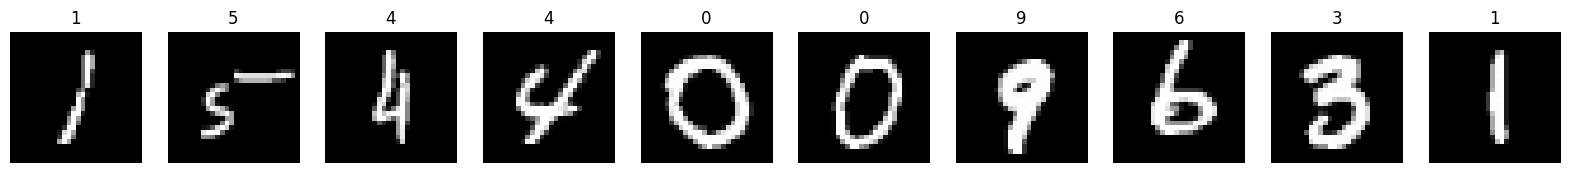

In [4]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 10, figsize=(20, 2))

data_loader = build_data_loader(batch_size=10)

for (images, labels) in data_loader:
    
    for i, (image, label) in enumerate(zip(images, labels)):
        axs[i].imshow(image.squeeze(), cmap="gray")
        axs[i].set_title(label.item())
        axs[i].axis("off")
    break

In [1]:
from torchvision.models import resnet18
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, lr: float = 1e-5):
    criterion = CrossEntropyLoss()

    model = resnet18()
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    
    model.to("cuda")
    data_loader = build_data_loader(batch_size)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Report the metrics
        print(f"Epoch {epoch}, Loss: {loss}")

In [5]:
train_loop_torch(num_epochs=2)

Epoch 0, Loss: 0.3510310649871826
Epoch 1, Loss: 0.07451891899108887


### Tune

In [6]:
import ray
from ray import tune, train
from ray.tune.search import optuna
import numpy as np
from typing import Any


def my_simple_model(distance: np.ndarray, a: float) -> np.ndarray:
    return distance * a

def train_my_simple_model(config: dict[str, Any]) -> None: 
    distances = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    total_amts = distances * 10
    
    a = config["a"]
    predictions = my_simple_model(distances, a)
    rmse = np.sqrt(np.mean((total_amts - predictions) ** 2))

    train.report({"rmse": rmse})

In [7]:
tuner = tune.Tuner(
    trainable=train_my_simple_model,
    param_space={
        "a": tune.randint(0, 20), 
    },
    tune_config=tune.TuneConfig(
        metric="rmse",  
        mode="min",     
        num_samples=5,  
    ),
)
results = tuner.fit()

(train_my_simple_model pid=1102522) /home/ozkan/anaconda3/envs/ray-jupyter/lib/python3.11/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_my_simple_model pid=1102522)   _log_deprecation_warning(
2025-07-24 15:07:24,948	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ozkan/ray_results/train_my_simple_model_2025-07-24_15-06-55' in 0.0206s.
2025-07-24 15:07:24,963	INFO tune.py:1041 -- Total run time: 9.56 seconds (9.48 seconds for the tuning loop).


In [ ]:
best_result = results.get_best_result()
best_result

Result(
  metrics={'rmse': np.float64(0.0)},
  path='/home/ozkan/ray_results/train_my_simple_model_2025-07-24_15-06-55/train_my_simple_model_bcfe8_00004_4_a=10_2025-07-24_15-07-15',
  filesystem='local',
  checkpoint=None
)

: 